<a href="https://colab.research.google.com/github/Jems-Chawin/GANs-Udemy-Course/blob/main/WGAN_Exercise_GANs_Course_AI_Expert_Academy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN Exercise - Wasserstein GAN

> Train with **fashion MNIST** dataset

Similar to the DCGAN exercise, now instead of using the digits dataset you should train the GAN using the [fashion_mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset, to generate images of clothes and accessories.

More about the dataset:

* https://github.com/zalandoresearch/fashion-mnist
* https://www.tensorflow.org/datasets/catalog/fashion_mnist


To do this exercise:
* Instead of `tf.keras.datasets.mnist.load_data()` the code to load the set will be `tf.keras.datasets.fashion_mnist.load_data()`

The main change is only this; because, as we will see, the number of images of images and the resolution is the same as in the previous dataset.

Below will be shown the complete solution of the exercise - and at the end we will also put more comments about this change


## Importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.12.0'

## Loading and pre-processing the dataset

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
buffer_size = y_train.shape[0] #60000
batch_size = 256

X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

## Building the generator

We will use the same generator architecture that we used in the DCGAN implementation

In [ ]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh'))

  network.summary()

  return network

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [ ]:
noise = tf.random.normal([1, 100])
print(noise)

tf.Tensor(
[[-1.9826862  -0.10148555  0.6093735  -0.12261136 -0.72081965 -0.29348448
   0.15294571  0.03929844  0.45141098 -0.90673494  0.50987166  1.8233145
  -0.8576058   0.7361369  -0.46299708 -0.19018966  0.3773736   0.5905348
  -1.0238844   0.5374442   1.3788413   0.5946368   0.30149105  1.1226076
   0.14438872 -0.31195298  0.526069   -1.3264441  -1.1387748   0.00528517
   1.4163142   0.36564162  0.16272058  0.7403149   0.37279195  0.44857186
   0.7145946   0.31728396  0.05905448  0.61298794 -0.50556374  1.6535114
   0.3047372   0.26482978  1.1465404   0.62629855 -0.78999114 -2.0723736
   0.08228615  0.03673934 -1.7597804   1.6049416   1.2063079  -0.18585655
  -2.3365133  -1.1852108   0.29351348  0.9651869  -1.9142222  -1.3558604
  -0.45695546 -0.29761204  0.26361537  1.2812014  -0.18928115  0.14957003
  -0.0958822   0.22114643 -1.6753105   0.10272562 -0.38655353 -0.06528997
  -0.9647682   2.1023736   1.5083846  -0.02320448 -0.36175737 -1.059415
   0.36300328  0.82214814  1.431443

(1, 28, 28, 1)


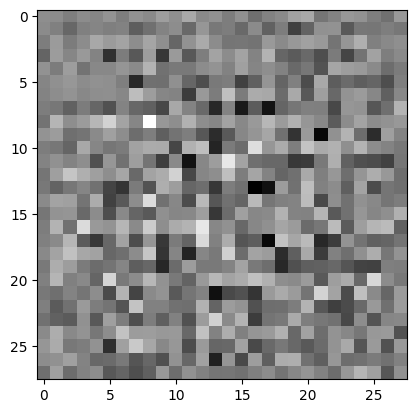

In [ ]:
generated_image = generator(noise, training = False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Building the discriminator

Note: In the context of WGAN, the discriminator is also called Critic

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
result = discriminator(generated_image)
print(result)

tf.Tensor([[-0.00252103]], shape=(1, 1), dtype=float32)



## **Wasserstein Loss**

The *loss* is the difference between the expected value of the discriminator output for authentic images and the expected value of the discriminator for false images that were generated.

* The objective of the discriminator is to maximize this difference, while the objective of the generator is to minimize it.

Then we can create the loss so we can monitor the training stages.

In [ ]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.95])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.68333334>

In [ ]:
def generator_loss(fake_output):
  g_loss = -1. * tf.math.reduce_mean(fake_output)
  return g_loss

In [ ]:
def discriminator_loss(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- beta parameters: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

To use Wasserstein loss, our discriminator needs to be **1-L** [(1-Lipschitz) continuous ](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt), that is, the gradient norm must be at most 1 at each point.

To enforce 1-L continuity we will use the concept of **Gradient Penalty**.

This variation was called **WGAN-GP** (due to the use of **G**radient **P**enalty)

(More about Gradient Penalty [in this article](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

To calculate the gradient penalty we will do the following:
1. Calculate an interpolated image from the real and fake image (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calculate the gradient of the discriminator output relative to the interpolated image. After that calculate the gradient norm.
3. Finally, the penalty is calculated as an average of the square of (norm - 1), as we want the norm to be close to one.

To work together with some of the operations involving gradient we use the [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [ ]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discrimanator_optimizer = discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training the GAN and visualizing the results

In [ ]:
epochs = 30
noise_dim = 100
num_images_to_generate = 16
seed = tf.random.normal([num_images_to_generate, noise_dim])

In [ ]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.34107095,  0.7378503 , -1.1637272 , ..., -0.05200141,
         1.1160781 ,  0.9443478 ],
       [-0.4833643 ,  1.5248654 , -1.2528971 , ..., -0.73027277,
         0.6770686 ,  0.32793078],
       [-1.2279816 , -1.3941486 ,  0.8757899 , ..., -0.32126704,
        -0.24697809,  0.71034515],
       ...,
       [-2.025577  , -1.2079773 , -1.2964878 , ..., -0.869121  ,
        -0.14703926, -0.8045908 ],
       [-0.13160156, -0.7560845 , -1.5045387 , ..., -0.23439398,
         0.37679592, -0.12774457],
       [ 1.3471622 ,  0.0379703 , -0.0206859 , ..., -0.62602013,
        -2.3598764 ,  0.35751018]], dtype=float32)>

In [ ]:
def train_step(imgs):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(imgs, training = True)
      fake_output = discriminator(generated_images, training=True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(imgs, generated_images, epsilon)

      d_loss = discriminator_loss(real_output, fake_output, gp)

    gradients_of_discriminator = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True)
    g_loss = generator_loss(fake_output)
  gradients_of_generator = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

About logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    inicio = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        train_step(img_batch)

    #display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time to process epoch {}: {} seconds'.format(epoch + 1, time.time() - inicio))

  #display.clear_output(wait = True)
  generate_and_save_images(generator, epochs, seed)
  generator.save('generator.h5')

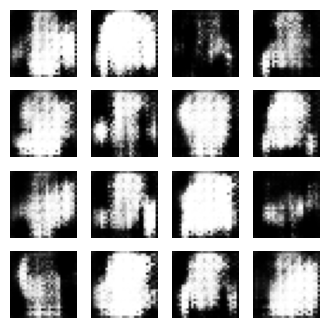

Time to process epoch 1: 64.01490139961243 seconds


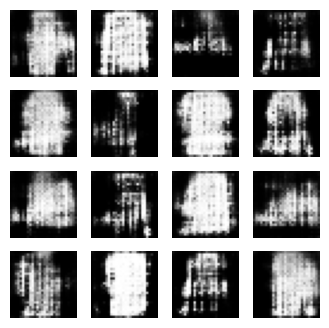

Time to process epoch 2: 58.543556213378906 seconds


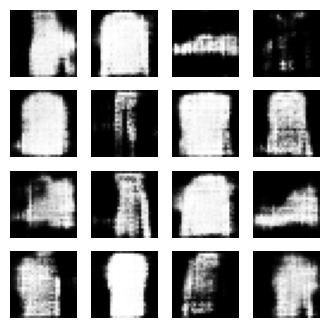

Time to process epoch 3: 58.5832622051239 seconds


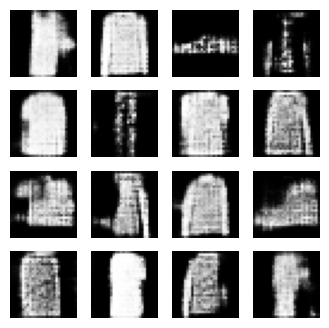

Time to process epoch 4: 59.297239542007446 seconds


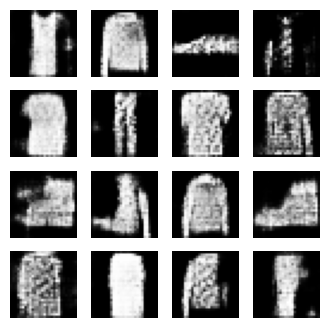

Time to process epoch 5: 58.9857394695282 seconds


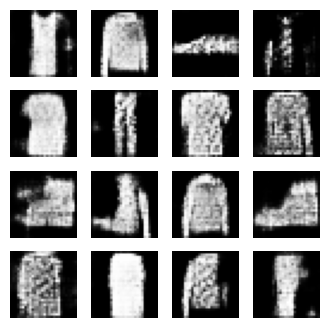

In [ ]:
train(X_train, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

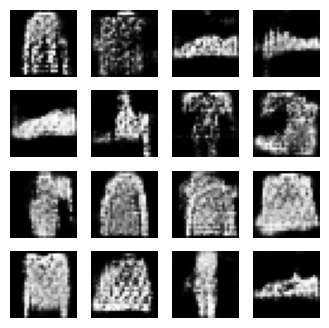

In [ ]:
seed_input = tf.random.normal([num_images_to_generate, noise_dim])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

Continuing training for another 10 epochs

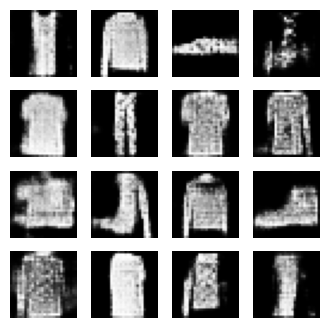

Time to process epoch 1: 65.02804255485535 seconds


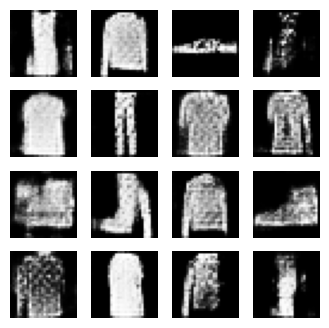

Time to process epoch 2: 58.42541456222534 seconds


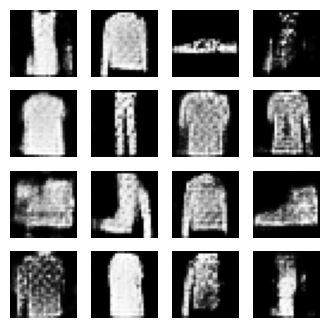

In [ ]:
train(X_train, 10)

> *Challenge*:
* modify structure and hyperparameters ([example](https://github.com/keras-team/keras-io/blob/master/examples/generative/ipynb/wgan_gp.ipynb))

To improve the results, you can modify the architecture of the discriminator, and also the generator if you want. If you want to test with more complex image sets then you will need to make adjustments and improvements to the architecture.

So far we have seen a simpler case study, where the dataset worked on is not very complex. In the next classes we will start working with more elaborate images, which will demand other architectures that are more prepared and focused on achieving the other objectives that we want with the GANs.

Although we have so far limited ourselves to simpler examples for DCGAN and WGAN (because they were more introductory classes to the concepts and so we can show how to create the architecture from scratch) you can increase their complexity even more and thus obtain very interesting results.

> Other implementations for more complex problems:

* https://github.com/robbiebarrat/art-DCGAN (based on DCGAN)
* https://github.com/tdrussell/IllustrationGAN (based on DCGAN)
* https://github.com/viuts/wgan-animefaces (based on WGAN)